<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Введение" data-toc-modified-id="Введение-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Введение</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель CatBoost</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель LightGBM</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Определение стоимости автомобилей

## Введение

В данном проекте будут построены модели для определения рыночной стоимости автомобиля с учётом технических характеристик и комплектации для сервиса по продаже автомобилей.
Для каждой модели будут рассчитаны метрики качества (RMSE и R2), а также скорость предсказания и время обучения.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(precision=3,suppress=True)
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
import time
from sklearn.preprocessing import OrdinalEncoder

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')

except:
    data = pd.read_csv('C:/Users/Lantana/Documents/data_science/11_numbers/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715,0.000,50508.689
std,4514.159,90.228,189.850,37905.342,3.726,0.000,25783.096
min,0.000,1000.000,0.000,5000.000,0.000,0.000,1067.000
25%,1050.000,1999.000,69.000,125000.000,3.000,0.000,30165.000
50%,2700.000,2003.000,105.000,150000.000,6.000,0.000,49413.000
75%,6400.000,2008.000,143.000,150000.000,9.000,0.000,71083.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.000,99998.000


Приведём названия столбцов к нижнему регистру.

In [6]:
data.columns = data.columns.str.lower()

In [7]:
data.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [8]:
data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Переведём столбцы с датами в формат даты и времени.

In [9]:
data['datecrawled'] = pd.to_datetime(data['datecrawled'], format='%Y-%m-%dT%H:%M:%S')
data['datecreated'] = pd.to_datetime(data['datecreated'], format='%Y-%m-%dT%H:%M:%S')
data['lastseen'] = pd.to_datetime(data['lastseen'], format='%Y-%m-%dT%H:%M:%S')
data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Заменим типы данных в столбцах на наиболее подходящие

In [10]:
data['price'] = data['price'].astype('uint32')
data['registrationyear'] = data['registrationyear'].astype('uint16')
data['power'] = data['power'].astype('uint16')
data['kilometer'] = data['kilometer'].astype('uint32')

Удалим стоблец numberofpictures, т.к. там все значения нулевые.

In [11]:
del data['numberofpictures']

Удалим столбцы postalcode, lastseen, datecrawled и datecreated, т.к. они имеют отношение только к владельцу автомобиля и не имеют отношения к самому автомобилю.
Также удалим столбцы с месяцем регистрации. Машины старые. И месяц не будет иметь значения.

In [12]:
del data['postalcode']
del data['datecreated']
del data['lastseen']
del data['registrationmonth']
del data['datecrawled']

Text(0.5, 1.0, 'Цены')

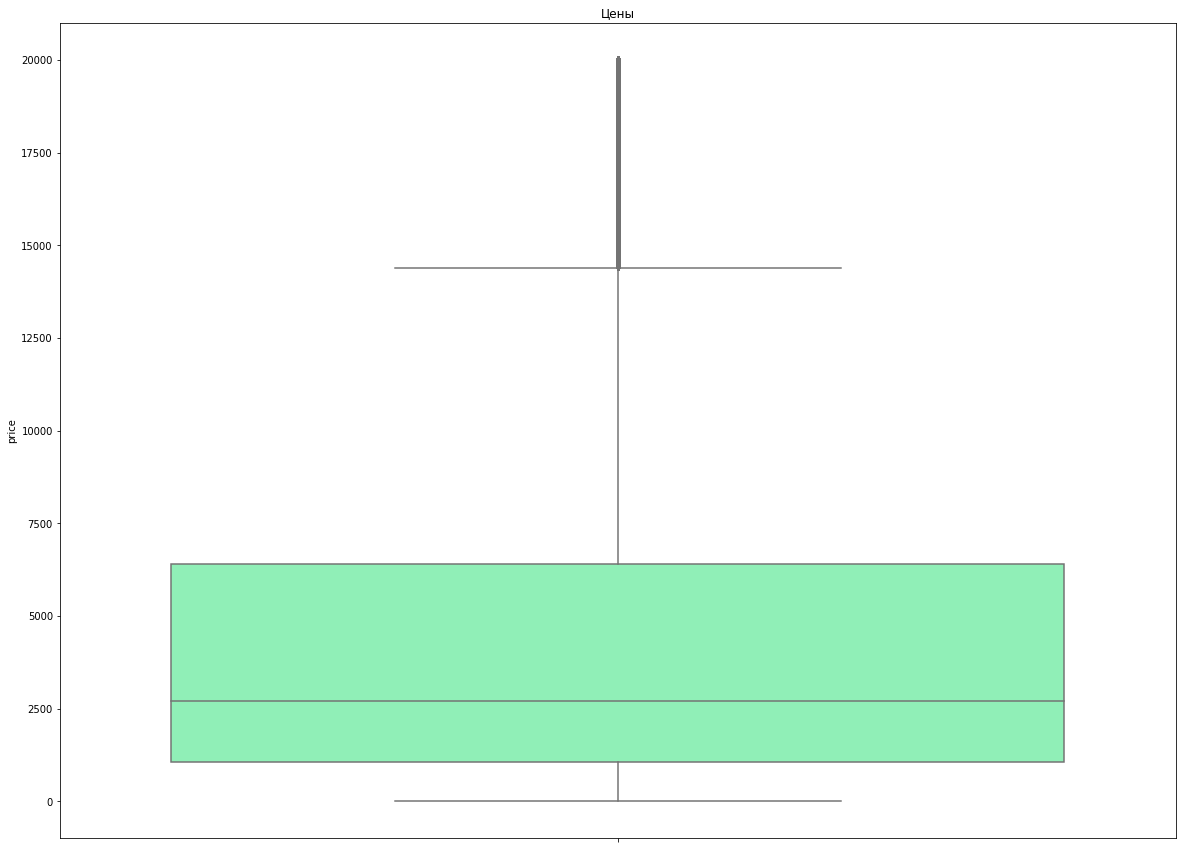

In [13]:
plt.figure(figsize=(20, 15))
sns.boxplot(y="price", data = data, palette='rainbow')
plt.title('Цены')

Автомобиль не может стоить менее 500 евро. Удалим все строки с мЕньшими значениями (около 10% данных)

In [14]:
data = data.query('price > 500')

Заполним пропуски в столбце model значением other. 

In [15]:
data['model'] = data['model'].fillna('other')


Удалим автомобили младше 1950 года или старше 2020. Это ошибки данных или очень раритетные автомобили, требующие отдельной оценки.

In [16]:
data = data.query('registrationyear > 1950 and registrationyear < 2021')
data

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354365,2200,NaN,2005,NaN,0,other,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


notrepaired - есть ли поломки, которые не восстановлены. Если не указано, заполним нулями

In [17]:
data['notrepaired'] = data['notrepaired'].fillna('no')


Обработаем пропуски в столбце **vehicletype**

In [18]:
data_without_null_vehicle_type = data[data['vehicletype'].isna() != True]

Создадим словарь соотнесения моделей с типами кузова

In [19]:
model_dictionary = data_without_null_vehicle_type.groupby("model")['vehicletype'].agg(lambda x:x.value_counts().index[0]).to_dict()
model_dictionary

{'100': 'sedan',
 '145': 'small',
 '147': 'sedan',
 '156': 'wagon',
 '159': 'wagon',
 '1_reihe': 'small',
 '1er': 'sedan',
 '200': 'sedan',
 '2_reihe': 'small',
 '300c': 'wagon',
 '3_reihe': 'sedan',
 '3er': 'sedan',
 '4_reihe': 'wagon',
 '500': 'small',
 '5_reihe': 'bus',
 '5er': 'sedan',
 '601': 'sedan',
 '6_reihe': 'wagon',
 '6er': 'coupe',
 '7er': 'sedan',
 '80': 'sedan',
 '850': 'wagon',
 '90': 'sedan',
 '900': 'convertible',
 '9000': 'sedan',
 '911': 'coupe',
 'a1': 'small',
 'a2': 'small',
 'a3': 'sedan',
 'a4': 'wagon',
 'a5': 'coupe',
 'a6': 'wagon',
 'a8': 'sedan',
 'a_klasse': 'sedan',
 'accord': 'sedan',
 'agila': 'small',
 'alhambra': 'bus',
 'almera': 'sedan',
 'altea': 'bus',
 'amarok': 'suv',
 'antara': 'suv',
 'arosa': 'small',
 'astra': 'sedan',
 'auris': 'sedan',
 'avensis': 'wagon',
 'aveo': 'small',
 'aygo': 'small',
 'b_klasse': 'bus',
 'b_max': 'bus',
 'beetle': 'sedan',
 'berlingo': 'bus',
 'bora': 'sedan',
 'boxster': 'convertible',
 'bravo': 'sedan',
 'c1': 's

In [20]:
data['vehicletype'] = data['vehicletype'].fillna(0)

In [21]:
print(data['vehicletype'].value_counts())

sedan          84107
small          66310
wagon          59810
bus            27648
0              26145
convertible    19433
coupe          14639
suv            11674
other           2714
Name: vehicletype, dtype: int64


Напишем функцию по замене пропущенных значений в столбце Тип кузова.

In [22]:
def replacement(row):
    model = row['model']
    vehicletype = row['vehicletype']
    if vehicletype != 0:
        return vehicletype
    if vehicletype == 0:
        return model_dictionary[model]  

In [23]:
data.head(10)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes


Применим функцию

In [24]:
data['vehicletype'] = data[['model','vehicletype']].apply(replacement, axis = 1)

In [25]:
data.head(10)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes


In [26]:
print(data['vehicletype'].value_counts())

sedan          98626
small          71934
wagon          62228
bus            30344
convertible    19639
coupe          14927
suv            12068
other           2714
Name: vehicletype, dtype: int64


Обработаем пропуски в столбце **gearbox**

Создадим словарь соотнесения моделей с типом коробки передач

In [27]:
data_without_null_gearbox = data[data['gearbox'].isna() != True]

In [28]:
gearbox_dictionary = data_without_null_gearbox.groupby("model")['gearbox'].agg(lambda x:x.value_counts().index[0]).to_dict()
gearbox_dictionary

{'100': 'manual',
 '145': 'manual',
 '147': 'manual',
 '156': 'manual',
 '159': 'manual',
 '1_reihe': 'manual',
 '1er': 'manual',
 '200': 'manual',
 '2_reihe': 'manual',
 '300c': 'auto',
 '3_reihe': 'manual',
 '3er': 'manual',
 '4_reihe': 'manual',
 '500': 'manual',
 '5_reihe': 'manual',
 '5er': 'auto',
 '601': 'manual',
 '6_reihe': 'manual',
 '6er': 'auto',
 '7er': 'auto',
 '80': 'manual',
 '850': 'manual',
 '90': 'manual',
 '900': 'manual',
 '9000': 'manual',
 '911': 'manual',
 'a1': 'manual',
 'a2': 'manual',
 'a3': 'manual',
 'a4': 'manual',
 'a5': 'manual',
 'a6': 'auto',
 'a8': 'auto',
 'a_klasse': 'manual',
 'accord': 'manual',
 'agila': 'manual',
 'alhambra': 'manual',
 'almera': 'manual',
 'altea': 'manual',
 'amarok': 'manual',
 'antara': 'manual',
 'arosa': 'manual',
 'astra': 'manual',
 'auris': 'manual',
 'avensis': 'manual',
 'aveo': 'manual',
 'aygo': 'manual',
 'b_klasse': 'manual',
 'b_max': 'manual',
 'beetle': 'manual',
 'berlingo': 'manual',
 'bora': 'manual',
 'box

In [29]:
data['gearbox'] = data['gearbox'].fillna(0)

In [30]:
print(data['gearbox'].value_counts())

manual    236758
auto       62918
0          12804
Name: gearbox, dtype: int64


Напишем функцию по замене пропущенных значений в столбце Тип коробки передач

In [31]:
def replacement_gearbox(row):
    model = row['model']
    gearbox = row['gearbox']
    if gearbox != 0:
        return gearbox
    if gearbox == 0:
        return gearbox_dictionary[model]  

Применим функцию

In [32]:
data['gearbox'] = data[['model','gearbox']].apply(replacement_gearbox, axis = 1)

In [33]:
print(data['gearbox'].value_counts())

manual    248097
auto       64383
Name: gearbox, dtype: int64


In [34]:
data.head(10)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes


Обработаем пропуски в столбце **fueltype**
Создадим словарь соотнесения моделей с типом топлива

In [35]:
data_without_null_fuel = data[data['fueltype'].isna() != True]

In [36]:
fueltype_dictionary = data_without_null_fuel.groupby("model")['fueltype'].agg(lambda x:x.value_counts().index[0]).to_dict()
fueltype_dictionary

{'100': 'petrol',
 '145': 'petrol',
 '147': 'petrol',
 '156': 'petrol',
 '159': 'gasoline',
 '1_reihe': 'petrol',
 '1er': 'petrol',
 '200': 'petrol',
 '2_reihe': 'petrol',
 '300c': 'gasoline',
 '3_reihe': 'petrol',
 '3er': 'petrol',
 '4_reihe': 'gasoline',
 '500': 'petrol',
 '5_reihe': 'gasoline',
 '5er': 'gasoline',
 '601': 'petrol',
 '6_reihe': 'petrol',
 '6er': 'petrol',
 '7er': 'petrol',
 '80': 'petrol',
 '850': 'petrol',
 '90': 'petrol',
 '900': 'petrol',
 '9000': 'petrol',
 '911': 'petrol',
 'a1': 'petrol',
 'a2': 'petrol',
 'a3': 'petrol',
 'a4': 'gasoline',
 'a5': 'gasoline',
 'a6': 'gasoline',
 'a8': 'gasoline',
 'a_klasse': 'petrol',
 'accord': 'petrol',
 'agila': 'petrol',
 'alhambra': 'gasoline',
 'almera': 'petrol',
 'altea': 'gasoline',
 'amarok': 'gasoline',
 'antara': 'gasoline',
 'arosa': 'petrol',
 'astra': 'petrol',
 'auris': 'petrol',
 'avensis': 'petrol',
 'aveo': 'petrol',
 'aygo': 'petrol',
 'b_klasse': 'petrol',
 'b_max': 'petrol',
 'beetle': 'petrol',
 'berling

In [37]:
data['fueltype'] = data['fueltype'].fillna(0)

In [38]:
print(data['fueltype'].value_counts())

petrol      188417
gasoline     95672
0            22458
lpg           4976
cng            530
hybrid         223
other          121
electric        83
Name: fueltype, dtype: int64


Напишем функцию по замене пропущенных значений в столбце Тип топлива

In [39]:
def replacement_fueltype(row):
    model = row['model']
    fueltype = row['fueltype']
    if fueltype != 0:
        return fueltype
    if fueltype == 0:
        return fueltype_dictionary[model]  

Применим функцию

In [40]:
data['fueltype'] = data[['model','fueltype']].apply(replacement_fueltype, axis = 1)

In [41]:
print(data['fueltype'].value_counts())

petrol      206786
gasoline     99761
lpg           4976
cng            530
hybrid         223
other          121
electric        83
Name: fueltype, dtype: int64


In [42]:
data.head(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Обработаем пропуски в столбце **power**

Создадим словарь соотнесения моделей с медианными значениями мощности.

In [43]:
data_grouped_power = data.groupby(['model'])['power'].median().to_dict()
data_grouped_power

{'100': 133.0,
 '145': 103.0,
 '147': 120.0,
 '156': 150.0,
 '159': 170.0,
 '1_reihe': 60.0,
 '1er': 143.0,
 '200': 182.0,
 '2_reihe': 90.0,
 '300c': 218.0,
 '3_reihe': 109.0,
 '3er': 150.0,
 '4_reihe': 136.0,
 '500': 69.0,
 '5_reihe': 143.0,
 '5er': 177.0,
 '601': 26.0,
 '6_reihe': 130.0,
 '6er': 333.0,
 '7er': 235.0,
 '80': 90.0,
 '850': 144.0,
 '90': 136.0,
 '900': 141.0,
 '9000': 170.0,
 '911': 300.0,
 'a1': 90.0,
 'a2': 75.0,
 'a3': 125.0,
 'a4': 140.0,
 'a5': 190.0,
 'a6': 179.0,
 'a8': 275.0,
 'a_klasse': 95.0,
 'accord': 147.0,
 'agila': 60.0,
 'alhambra': 116.0,
 'almera': 90.0,
 'altea': 125.0,
 'amarok': 163.0,
 'antara': 150.0,
 'arosa': 50.0,
 'astra': 101.0,
 'auris': 124.0,
 'avensis': 129.0,
 'aveo': 86.0,
 'aygo': 68.0,
 'b_klasse': 116.0,
 'b_max': 97.5,
 'beetle': 105.0,
 'berlingo': 90.0,
 'bora': 110.0,
 'boxster': 220.0,
 'bravo': 120.0,
 'c1': 68.0,
 'c2': 68.0,
 'c3': 73.0,
 'c4': 109.0,
 'c5': 136.0,
 'c_klasse': 143.0,
 'c_max': 116.0,
 'c_reihe': 140.0,
 'cad

In [44]:
data.describe()

,price,registrationyear,power,kilometer
count,312480.000,312480.000,312480.000,312480.000
mean,4973.478,2003.591,115.675,127879.208
std,4520.692,7.082,188.909,37227.116
min,501.000,1951.000,0.000,5000.000
25%,1500.000,2000.000,75.000,125000.000
50%,3300.000,2004.000,109.000,150000.000
75%,6999.000,2008.000,147.000,150000.000
max,20000.000,2019.000,20000.000,150000.000


Напишем функцию по замене пропущенных значений в столбце Тип топлива

In [45]:
def replacement_power(row):
    model = row['model']
    power = row['power']
    if power != 0:
        return power
    if power == 0:
        return data_grouped_power[model]  

Применим функцию

In [46]:
data['power'] = data[['model','power']].apply(replacement_power, axis = 1)

In [47]:
data.describe()

,price,registrationyear,power,kilometer
count,312480.000,312480.000,312480.000,312480.000
mean,4973.478,2003.591,125.260,127879.208
std,4520.692,7.082,185.852,37227.116
min,501.000,1951.000,0.000,5000.000
25%,1500.000,2000.000,82.000,125000.000
50%,3300.000,2004.000,114.000,150000.000
75%,6999.000,2008.000,150.000,150000.000
max,20000.000,2019.000,20000.000,150000.000


отберём только строки со  значениями более 26 и менее 550 л.с. Всё остальное - игрушечные машины или ошибки в данных.

In [48]:
data = data.query('power >= 26 and power <= 550')

In [49]:
data['power'] = data['power'].astype('uint16')

In [50]:
data.head(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [51]:
data.describe()

,price,registrationyear,power,kilometer
count,311702.000,311702.000,311702.000,311702.000
mean,4974.796,2003.606,121.973,127988.207
std,4522.006,7.041,52.498,37099.326
min,501.000,1951.000,26.000,5000.000
25%,1500.000,2000.000,82.000,125000.000
50%,3300.000,2004.000,114.000,150000.000
75%,6999.000,2008.000,150.000,150000.000
max,20000.000,2019.000,550.000,150000.000


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311702 entries, 1 to 354368
Data columns (total 10 columns):
price               311702 non-null uint32
vehicletype         311702 non-null object
registrationyear    311702 non-null uint16
gearbox             311702 non-null object
power               311702 non-null uint16
model               311702 non-null object
kilometer           311702 non-null uint32
fueltype            311702 non-null object
brand               311702 non-null object
notrepaired         311702 non-null object
dtypes: object(6), uint16(2), uint32(2)
memory usage: 20.2+ MB


***Вывод***
В данных больше нет пропусков, некорректных значений и ненужных столбцов.
Данные готовы к моделированию.

## Обучение моделей

Для простых моделей произведём кодирование:
Создадим Dummy-переменные для столбцов ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']. Применим параметр drop_first=True, чтобы избежать dummy-ловушки.
Для столбцов: ['RegistrationYear', 'Model', 'Brand', 'PostalCode'] применим порядковое кодирование.

In [53]:
# Выделим категориальные признаки для one-hot
categorial_ohe = ['vehicletype', 'gearbox', 'fueltype', 'notrepaired']
# Категориальные для ordinal
categorial_ord = ['registrationyear', 'model', 'brand']
# И количественные
#numeric = ['kilometer', 'power']

In [54]:
data_ohe = pd.get_dummies(data=data, columns=categorial_ohe, drop_first=True)
data_ohe = data_ohe.reset_index()

In [55]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data_ohe[categorial_ord]), columns = categorial_ord)
data_ordinal.reset_index()
display(data_ordinal.head())

,registrationyear,model,brand
0,60.000,166.000,1.000
1,53.000,117.000,14.000
2,50.000,116.000,38.000
3,57.000,101.000,31.000
4,44.000,11.000,2.000


In [56]:
data_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311702 entries, 0 to 311701
Data columns (total 3 columns):
registrationyear    311702 non-null float64
model               311702 non-null float64
brand               311702 non-null float64
dtypes: float64(3)
memory usage: 7.1 MB


In [57]:
data_ohe[categorial_ord] = data_ordinal[categorial_ord]


In [58]:
del data_ohe['index']
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311702 entries, 0 to 311701
Data columns (total 21 columns):
price                      311702 non-null uint32
registrationyear           311702 non-null float64
power                      311702 non-null uint16
model                      311702 non-null float64
kilometer                  311702 non-null uint32
brand                      311702 non-null float64
vehicletype_convertible    311702 non-null uint8
vehicletype_coupe          311702 non-null uint8
vehicletype_other          311702 non-null uint8
vehicletype_sedan          311702 non-null uint8
vehicletype_small          311702 non-null uint8
vehicletype_suv            311702 non-null uint8
vehicletype_wagon          311702 non-null uint8
gearbox_manual             311702 non-null uint8
fueltype_electric          311702 non-null uint8
fueltype_gasoline          311702 non-null uint8
fueltype_hybrid            311702 non-null uint8
fueltype_lpg               311702 non-null uint

In [59]:
data_ohe.head()

,price,registrationyear,power,model,kilometer,brand,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,gearbox_manual,fueltype_electric,fueltype_gasoline,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_petrol,notrepaired_yes
0,18300,60.000,190,166.000,125000,1.000,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1
1,9800,53.000,163,117.000,125000,14.000,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,1500,50.000,75,116.000,150000,38.000,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
3,3600,57.000,69,101.000,90000,31.000,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
4,650,44.000,102,11.000,150000,2.000,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1


Разделим данные на обучающую (train) и валидационную (valid) выборки в соотношении 75% - 25%. И извлечём признаки для обучения: целевой - target, остальные - features. Для бустинга из изначальной таблицы, без кодирования

In [60]:
target = data['price']
features = data.drop('price', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [61]:
features_train

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
42902,coupe,2006,auto,306,3er,150000,petrol,bmw,no
297066,sedan,2006,auto,149,1er,125000,petrol,bmw,no
265944,sedan,1993,auto,170,vectra,90000,petrol,opel,no
211959,small,2004,manual,105,other,100000,petrol,peugeot,no
91161,bus,1997,manual,74,transporter,150000,gasoline,volkswagen,yes
...,...,...,...,...,...,...,...,...,...
180654,sedan,1992,auto,133,100,150000,petrol,audi,yes
54479,sedan,1984,manual,90,3er,60000,petrol,bmw,no
98216,small,2008,manual,76,twingo,90000,petrol,renault,no
87854,sedan,1999,manual,90,escort,150000,petrol,ford,no


Для простых моделей - из кодированных данных

In [62]:
target_ohe = data_ohe['price']
features_ohe = data_ohe.drop('price', axis=1)
features_ohe_train, features_ohe_valid, target_ohe_train, target_ohe_valid = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=12345)

Масштабируем данные для простых моделей

In [63]:
numeric = ['power', 'kilometer', 'registrationyear', 'model', 'brand']

scaler = StandardScaler()
scaler.fit(features_ohe_train[numeric])
features_ohe_train[numeric] = scaler.transform(features_ohe_train[numeric])
features_ohe_valid[numeric] = scaler.transform(features_ohe_valid[numeric])

In [64]:
display(features_ohe_train.head())

,registrationyear,power,model,kilometer,brand,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,gearbox_manual,fueltype_electric,fueltype_gasoline,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_petrol,notrepaired_yes
37695,0.340,3.504,-1.416,0.593,-1.396,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
261246,0.340,0.514,-1.487,-0.081,-1.396,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
233793,-1.507,0.914,1.738,-1.025,0.245,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
186306,0.056,-0.324,0.786,-0.755,0.319,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
80206,-0.939,-0.914,1.596,0.593,1.289,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1


In [65]:
features_ohe_train.describe()

,registrationyear,power,model,kilometer,brand,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,gearbox_manual,fueltype_electric,fueltype_gasoline,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_petrol,notrepaired_yes
count,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000,233776.000
mean,0.000,-0.000,-0.000,0.000,0.000,0.063,0.048,0.009,0.316,0.229,0.039,0.199,0.795,0.000,0.319,0.001,0.016,0.000,0.662,0.079
std,1.000,1.000,1.000,1.000,1.000,0.243,0.213,0.092,0.465,0.420,0.193,0.400,0.404,0.012,0.466,0.027,0.125,0.019,0.473,0.269
min,-7.471,-1.829,-1.572,-3.316,-1.545,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.513,-0.762,-0.976,-0.081,-0.874,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.056,-0.152,0.076,0.593,0.170,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
75%,0.624,0.533,0.786,0.593,0.990,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000
max,2.186,8.152,1.951,0.593,1.363,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [66]:
features_ohe_train.sample(20)

,registrationyear,power,model,kilometer,brand,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,gearbox_manual,fueltype_electric,fueltype_gasoline,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_petrol,notrepaired_yes
6724,1.760,0.057,-0.109,0.593,-0.799,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
102710,-0.513,-0.895,0.885,0.593,1.289,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
206259,-1.081,-1.467,0.885,-1.025,1.289,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
169225,0.482,-0.705,0.076,0.593,1.289,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
243900,-0.513,-0.610,-1.430,0.593,0.319,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
157079,0.908,1.638,-1.416,0.593,-1.396,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
295277,-0.939,-0.400,-1.175,0.593,-1.471,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
5218,0.198,0.533,0.786,0.593,-1.247,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
303444,-0.655,-0.114,-0.876,0.593,1.289,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
213178,0.766,0.267,-0.223,0.593,-0.054,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


Рассмотрим модели линейной регрессии, случайного леса, CatBoost и LightGMB

### Модель линейной регрессии

In [67]:
%%time
model_regr = LinearRegression()
model_regr.fit(features_ohe_train, target_ohe_train)


CPU times: user 237 ms, sys: 112 ms, total: 349 ms
Wall time: 354 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
%%time
predicted_valid_regr = model_regr.predict(features_ohe_valid)

CPU times: user 20.4 ms, sys: 24 ms, total: 44.3 ms
Wall time: 84.9 ms


In [69]:
result_regr = mean_squared_error(target_ohe_valid, predicted_valid_regr) ** 0.5
print("RMSE модели линейной регрессии:", result_regr)
print("R2 линейной регрессии =", r2_score(target_ohe_valid, predicted_valid_regr))

RMSE модели линейной регрессии: 2987.194705894615
R2 линейной регрессии = 0.5651616075935684


### Модель случайного леса

Рассмотрим разные гиперпараметры для модели случайного леса

In [70]:
%%time
model_forest_1 = RandomForestRegressor(random_state=12345, n_estimators=10, max_depth=10)
model_forest_1.fit(features_ohe_train, target_ohe_train)

CPU times: user 5.26 s, sys: 47.2 ms, total: 5.3 s
Wall time: 5.36 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [71]:
%%time
predictions_forest_valid_1 = model_forest_1.predict(features_ohe_valid)

CPU times: user 97.4 ms, sys: 33 µs, total: 97.4 ms
Wall time: 107 ms


In [72]:
result_forest_1 = mean_squared_error(target_ohe_valid, predictions_forest_valid_1) ** 0.5
print("RMSE модели 1 случайного леса:", result_forest_1)
print("R2 модели 1 случайного леса =", r2_score(target_ohe_valid, predictions_forest_valid_1))

RMSE модели 1 случайного леса: 1965.5360710617845
R2 модели 1 случайного леса = 0.8117379184382902


In [73]:
%%time
model_forest_2 = RandomForestRegressor(random_state=12345, n_estimators=20, max_depth=9)
model_forest_2.fit(features_ohe_train, target_ohe_train)

CPU times: user 9.31 s, sys: 19.2 ms, total: 9.33 s
Wall time: 9.45 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [74]:
%%time
predictions_forest_valid_2 = model_forest_2.predict(features_ohe_valid)

CPU times: user 166 ms, sys: 4.04 ms, total: 170 ms
Wall time: 183 ms


In [75]:
result_forest_2 = mean_squared_error(target_ohe_valid, predictions_forest_valid_2) ** 0.5
print("RMSE модели 1 случайного леса:", result_forest_2)
print("R2 модели 1 случайного леса =", r2_score(target_ohe_valid, predictions_forest_valid_2))

RMSE модели 1 случайного леса: 2035.4847312100133
R2 модели 1 случайного леса = 0.7980999076666253


***Вывод***
Лучшей оказалась модель случайного леса с количеством деревьев = 10 и глубиной = 10

### Модель CatBoost

In [76]:
%%time
cat_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

model_cat = CatBoostRegressor(loss_function='RMSE', random_seed=12345, iterations=150)
model_cat.fit(features_train, target_train, cat_features=cat_features, verbose=10)

0:	learn: 4432.8007907	total: 445ms	remaining: 1m 6s
10:	learn: 3732.8344691	total: 3.64s	remaining: 45.9s
20:	learn: 3239.2811037	total: 6.73s	remaining: 41.4s
30:	learn: 2899.8946297	total: 9.73s	remaining: 37.4s
40:	learn: 2656.2665861	total: 12.9s	remaining: 34.4s
50:	learn: 2474.8397052	total: 15.9s	remaining: 30.9s
60:	learn: 2348.8988373	total: 18.9s	remaining: 27.6s
70:	learn: 2257.1362055	total: 22s	remaining: 24.5s
80:	learn: 2178.5626136	total: 25s	remaining: 21.3s
90:	learn: 2120.5211058	total: 28s	remaining: 18.1s
100:	learn: 2078.2821141	total: 31s	remaining: 15s
110:	learn: 2047.5883841	total: 34.1s	remaining: 12s
120:	learn: 2022.2184796	total: 37.1s	remaining: 8.88s
130:	learn: 2002.8191351	total: 40s	remaining: 5.79s
140:	learn: 1985.4089364	total: 43s	remaining: 2.74s
149:	learn: 1972.9860179	total: 45.6s	remaining: 0us
CPU times: user 41.7 s, sys: 4.92 s, total: 46.7 s
Wall time: 48.3 s


In [77]:
%%time
predictions_cat_valid = model_cat.predict(features_valid)

CPU times: user 236 ms, sys: 32.2 ms, total: 268 ms
Wall time: 244 ms


In [78]:
result_cat = mean_squared_error(target_valid, predictions_cat_valid) ** 0.5
print("RMSE для catboost:", result_cat)
print("R2 для catboost =", r2_score(target_valid, predictions_cat_valid))

RMSE для catboost: 1978.0359030334575
R2 для catboost = 0.8093357980672204


### Модель LightGBM

Расссмотрим модель LightGMB. Для того чтобы модель могла работать с категориальными признаками, переведём столбцы с ними к типу данных category. А потом списком передадим эти столбцы в модель.

In [79]:
data['vehicletype'] = data['vehicletype'].astype('category')
data['gearbox'] = data['gearbox'].astype('category')
data['model'] = data['model'].astype('category')
data['fueltype'] = data['fueltype'].astype('category')
data['brand'] = data['brand'].astype('category')
data['notrepaired'] = data['notrepaired'].astype('category')

In [80]:
target = data['price']
features = data.drop('price', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [81]:
%%time

cat_feature = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

model_light = LGBMRegressor(num_leaves = 31, max_depth = -1, random_state=12345, n_estimators=100, categorical_feature = cat_feature)
model_light.fit(features_train, target_train, verbose=10)

CPU times: user 8.59 s, sys: 39.2 ms, total: 8.63 s
Wall time: 8.7 s


LGBMRegressor(boosting_type='gbdt',
              categorical_feature=['vehicletype', 'gearbox', 'model',
                                   'fueltype', 'brand', 'notrepaired'],
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              learning_rate=0.1, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=31, objective=None, random_state=12345,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [82]:
%%time
predictions_light_valid = model_light.predict(features_valid)

CPU times: user 1.11 s, sys: 13.5 ms, total: 1.12 s
Wall time: 1.11 s


In [83]:
result_light = mean_squared_error(target_valid, predictions_light_valid) ** 0.5
print("RMSE для lightGBM:", result_light)
print("R2 для lightGBM =", r2_score(target_valid, predictions_light_valid))

RMSE для lightGBM: 1695.2310140663124
R2 для lightGBM = 0.8599579053717531


## Анализ моделей

Выведем итоговую таблицу с результатами качеством предсказания, временем обучения и скоростью предсказания для каждой рассмотренной модели

In [86]:
summary = pd.DataFrame({'model': ['regression', 'forest', 'CatBoostRegressor', 'LightGMBRegressor'], 'RMSE': [result_regr, result_forest_1, result_cat, result_light],  'R2': [0.56, 0.81, 0.81, 0.86],  'study_time': ['354 ms', '5.36 s', '47.3 s', '8.89 s'], 'predict_time': ['84.9 ms', '107 ms', '245 ms', '1.1 s']})
summary

,model,RMSE,R2,study_time,predict_time
0,regression,2987.195,0.560,354 ms,84.9 ms
1,forest,1965.536,0.810,5.36 s,107 ms
2,CatBoostRegressor,1978.036,0.810,47.3 s,245 ms
3,LightGMBRegressor,1695.231,0.860,8.89 s,1.1 s


***Вывод***

И по времени обучения, и по метрикам качества лидирует модель LightGMBRegressor

## Общий вывод

В данном проекте были построены модели для определения рыночной стоимости автомобиля с учётом технических характеристик и комплектации.
Изначально данные были подготовлены: данные приведены к нужным типам, заполнены пропуски, удалены ненужные столбцы.
Затем были построены модели линейной регрессии, случайного леса, CatBoostRegressor и LightGMBRegressor.
Для каждой модели были рассчитаны метрики качества (RMSE и R2), а также скорость предсказания и время обучения.
Наилучшие результаты показала модель LightGMBRegressor.